# Visualizing convnet filters

In [0]:
# Alhamdulillah visualization of activations is completed, now turn for filters

In [0]:
#Listing 5.32 - Defining the loss tensor for filter visualization
from keras.applications import VGG16
from keras import backend as K

model = VGG16(weights='imagenet', include_top=False)  # not configuring the input shape
layer_name = 'block3_conv1'
filter_index = 0
layer_output = model.get_layer(layer_name).output
loss = K.mean(layer_output[:,:,:,filter_index])

Using TensorFlow backend.


58892288/58889256 [==============================] - 3s 0us/step


In [0]:
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0     

In [0]:
# rough
print(layer_output) # nor able to print its slice
print(loss)
type(loss)

Tensor("block3_conv1/Relu:0", shape=(None, None, None, 256), dtype=float32)
Tensor("Mean:0", shape=(), dtype=float32)


tensorflow.python.framework.ops.Tensor

In [0]:
# Listing 5.33 - Obtaining the gradient of the loss with regard to the input
# you’ll use the gradients function packaged with the backend module of Keras

grads = K.gradients(loss, model.input)[0]    # extracting first tensor from: the list of tensors of size 1
grads

<tf.Tensor 'gradients/block1_conv1/convolution_grad/Conv2DBackpropInput:0' shape=(None, None, None, 3) dtype=float32>

In [0]:
# Listing 5.34 - Gradient-normalization trick
grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)   # 1e-5 to accidentally avoid divide by zero
grads

<tf.Tensor 'RealDiv:0' shape=(None, None, None, 3) dtype=float32>

In [0]:
# Removing Confusion: I think that the layer remains same i.e. layer 3, grads has nothing to do with the input layer.

In [0]:
#Listing 5.35 - Fetching Numpy output values given Numpy input values
# using keras backend function to do this
# this cell is complex to understand technically
iterate = K.function([model.input], [loss, grads])

import numpy as np
loss_value, grads_value = iterate([np.zeros((1,150,150,3))])

In [0]:
# rough
print(loss_value)
print(grads_value.shape)
#grads_value[0].shape
#grads_value[0][149]

0.0
(1, 150, 150, 3)


In [0]:
# Explore: not able to findout myself that how K.function() works. Maybe we can search it on google.

In [0]:
# Listing 5.36 - Loss maximization via stochastic gradient descent
input_image_data = np.random.random((1,150,150,3)) * 20 + 128      # starting from a noisy gray image
step = 1  # magnitude of each gradient update

for i in range(40):   # Gradient ascent
  loss_value, grads_value = iterate([input_image_data])  # computes the loss value and gradient value
  input_image_data += grads_value * step    # Adjusts the input image in the direction that maximizes the loss

In [0]:
# I think the above cell is gradient ascent, not descent.

In [0]:
# rough:
np.zeros((4,2)) * 20 + 128

array([[128., 128.],
       [128., 128.],
       [128., 128.],
       [128., 128.]])

In [0]:
# rough:
input_image_data[0][0].shape

(150, 3)

In [0]:
print(loss_value)
input_image_data.shape

4779.8022


(1, 150, 150, 3)

In [0]:
# we need to postprocess this tensor to [0,255]
# Listing 5.37 - Utility function to convert a tensor into a valid image
def deprocess_image(x):
  #Normalizes the tensor: centers on 0, ensures that std is 0.1
  x -= x.mean()
  x /= (x.std() + 1e-5)
  x *= 0.1

  x+=0.5
  x=np.clip(x,0,1)
  x*=255
  x = np.clip(x,0,255).astype('uint8')
  return x

In [0]:
# Main Listing 5.38 - Function to generate filter visualizations
def generate_pattern(layer_name, filter_index, size=100):
  layer_output = model.get_layer(layer_name).output
  loss = K.mean(layer_output[:,:,:,filter_index])
  grads = K.gradients(loss, model.input)[0]
  grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
  iterate = K.function([model.input],[loss,grads])
  input_img_data = np.random.random((1,size,size,3)) * 20 + 128.
  step = 1.

  for i in range(40):
    loss_value, grads_value = iterate([input_img_data])
    input_img_data += grads_value * step
  img = input_img_data[0]
  return deprocess_image(img) # calling a function before return

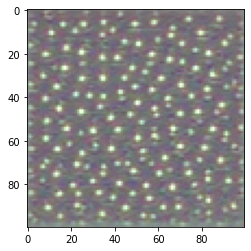

In [0]:
import matplotlib.pyplot as plt
plt.imshow(generate_pattern('block3_conv1', 0))
#plt.grid()

In [0]:
#Listing 5.39 - Generating a grid of all filter response patterns in a layer
# 8 × 8 grid of 64 × 64 filter patterns, with some black margins in between
for layer_name in ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']:
  size = 64
  margin = 5
  results = np.zeros((8*size+7*margin, 8*size+7*margin, 3))

  for i in range(8):
    for j in range(8):
      filter_img = generate_pattern(layer_name, i+(j*8), size=size)  # i+(j*8) refers to a filter number out of 64[0,63]
      horizontal_start = i * size + i * margin
      horizontal_end = horizontal_start + size
      vertical_start = j*size+j*margin
      vertical_end = vertical_start + size
      results[horizontal_start:horizontal_end, vertical_start: vertical_end, :] = filter_img

  plt.figure(figsize=(20,20))
  plt.imshow(results/255)

In [0]:
# Use TAB for suggestions

In [0]:
# rough
size = 150
import matplotlib.pyplot as plt
import numpy as np
z = np.random.random((size,size,3)) * 20 + 128
plt.imshow(z/255)

In [0]:
#z[60:80,50:100,:] = 255
# plt.figure(figsize=(20,20))
# plt.imshow(z/255)